In [1]:
BLOCKS_HORIZONTAL = 20
BLOCKS_VERTICAL = 18
BLOCK_COUNT = 192
BLOCK_WIDTH = 8

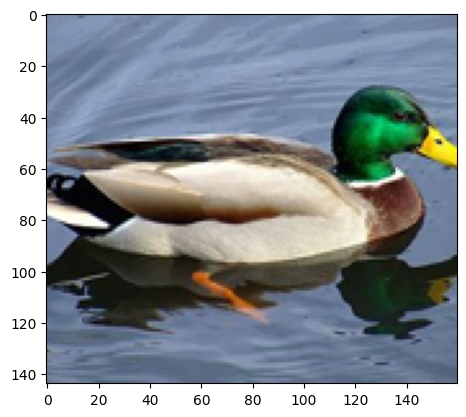

In [2]:
from PIL import Image
import numpy as np
from matplotlib.pyplot import imshow, show

def resize_and_crop(image_path, desired_width, desired_height):
    # Open the image using Pillow
    image = Image.open(image_path)
    original_width, original_height = image.size
    
    # Calculate the aspect ratios
    original_aspect = original_width / original_height
    desired_aspect = desired_width / desired_height

    # Resize the image while maintaining aspect ratio
    if original_aspect > desired_aspect:
        # Image is wider than desired aspect ratio
        new_height = desired_height
        new_width = int(new_height * original_aspect)
    else:
        # Image is taller than desired aspect ratio
        new_width = desired_width
        new_height = int(new_width / original_aspect)
    
    image = image.resize((new_width, new_height))
    
    # Calculate cropping coordinates
    left = (new_width - desired_width) / 2
    top = (new_height - desired_height) / 2
    right = left + desired_width
    bottom = top + desired_height

    # Crop the image
    image = image.crop((left, top, right, bottom))

    # Convert the image to a numpy array
    image_array = np.array(image)
    
    return image_array

# duck_cropped = resize_and_crop("duck.jpg", BLOCK_WIDTH * BLOCKS_HORIZONTAL, BLOCK_WIDTH * BLOCKS_VERTICAL)
# duck_goal = duck_cropped / 255
# imshow(duck_cropped)

In [3]:
BLOCKS_HORIZONTAL = 20
BLOCKS_VERTICAL = 18
BLOCK_COUNT = 192
BLOCK_WIDTH = 8

# import colorsys

# def hue_difference_rgb(x):
#     hue1 = colorsys.rgb_to_hsv(x[0], x[1], x[2])[0] * 360
#     hue2 = colorsys.rgb_to_hsv(x[3], x[4], x[5])[0] * 360
#     diff = abs(hue1 - hue2)
#     return min(diff, 360 - diff)

def block_dif(A, B):
    err = np.sum((A - B)**2)
    # stack = np.concatenate((A, B), axis=2)
    # hue_dif = np.apply_along_axis(hue_difference_rgb, 2, stack)
    # err = np.sum(hue_dif)
    return err

def block_correlation(img):
    K = BLOCKS_HORIZONTAL * BLOCKS_VERTICAL
    block_difs = np.zeros((K, K))

    for i0 in range(BLOCKS_VERTICAL):
        for j0 in range(BLOCKS_HORIZONTAL):
            u = i0 * BLOCKS_HORIZONTAL + j0
            x0 = j0 * BLOCK_WIDTH
            y0 = i0 * BLOCK_WIDTH
            block0 = img[y0:y0 + BLOCK_WIDTH, x0:x0 + BLOCK_WIDTH]
            
            for i1 in range(BLOCKS_VERTICAL):
                for j1 in range(BLOCKS_HORIZONTAL):
                    v = i1 * BLOCKS_HORIZONTAL + j1
                    x1 = j1 * BLOCK_WIDTH
                    y1 = i1 * BLOCK_WIDTH
                    block1 = img[y1:y1 + BLOCK_WIDTH, x1:x1 + BLOCK_WIDTH]

                    block_difs[u, v] = block_dif(block0, block1)
    
    return block_difs


# duck_corr = block_correlation(duck_goal)
# print(duck_difs.shape)
# print(duck_difs)

# imshow(duck_corr)

In [4]:

def solve(adj_matrix):
    n, _ = adj_matrix.shape
    edges = []
    for i in range(n):
        for j in range(i+1, n):
            edges.append((i, j, adj_matrix[i, j]))
    
    
    edges.sort(key=lambda x: x[2])

    comps = [ [i] for i in range(n) ]
    
    # merge components where least difference until only 192 left
    k = n
    for (i, j, dif) in edges:
        if k <= BLOCK_COUNT:
            break

        c1 = comps[i]
        c2 = comps[j]

        if c1 == c2:
            continue

        for u in c2:
            comps[u] = c1
            c1.append(u)

        assert comps[i] == comps[j]

        k -= 1

    unique = []
    for c in comps:
        if not c in unique:
            unique.append(c)
    
    return unique

    # # index components
    # # mapping = np.zeros((n,), dtype=np.int64)
    # blocks = []
    # seen_comps = []    
    # # i = 0
    # for comp in comps:
    #     if comp in seen_comps:
    #         continue
    #     seen_comps.append(comp)
    #     for j in comp:
    #         blocks.append(comp)
    #         # mapping[j] = i
    #     # i += 1

    # return mapping.reshape((BLOCKS_VERTICAL, BLOCKS_HORIZONTAL))
        
# mapping = solve(duck_corr)


In [5]:
import random

def get_block(img, i):
    x = (i // BLOCKS_HORIZONTAL) * BLOCK_WIDTH
    y = (i % BLOCKS_HORIZONTAL) * BLOCK_WIDTH
    return img[x:x+BLOCK_WIDTH,y:y+BLOCK_WIDTH]

def reconstruct(goal_img, mapping):
    final_img = np.zeros(goal_img.shape)
    
    for comp in mapping:
        all_blocks = [ get_block(goal_img, u) for u in comp ]
        block = np.median(np.array(all_blocks), axis=0)
        # block = all_blocks[0]
        # block = all_blocks[random.randint(0, len(all_blocks)-1)]
        
        for u in comp:
            x = (u // BLOCKS_HORIZONTAL) * BLOCK_WIDTH
            y = (u % BLOCKS_HORIZONTAL) * BLOCK_WIDTH
            final_img[x:x+BLOCK_WIDTH,y:y+BLOCK_WIDTH] = block
    return final_img


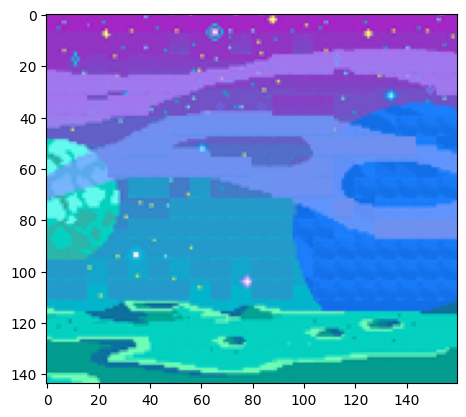

In [7]:

def full_method(img):
    correlation = block_correlation(img)
    mapping = solve(correlation)
    return reconstruct(img, mapping)

test_img = resize_and_crop("pixelart.png", BLOCK_WIDTH * BLOCKS_HORIZONTAL, \
                             BLOCK_WIDTH * BLOCKS_VERTICAL) / 255

result = full_method(test_img)

imshow(result)
